This notebook has been made to determine a rough estimate of the receiver temperature and its error bars. This has been done by using the process described in Adam Beardsley's [memo](http://reionization.org/wp-content/uploads/2017/04/HERA19_Tsys_3April2017.pdf), which fit auto-correlation data to a simulated global sky model using the relationship.

In [1]:
import numpy as np
from scipy.optimize import curve_fit
from scipy import interpolate
import matplotlib.pyplot as plt
import aipy
from astropy.io import fits
from scipy.stats import linregress
import os
import glob

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

In [2]:
def curve_to_fit(lsts, gain, offset):
    '''
    Define curve to fit data to
    offset is Tsys offset from zero = Trxr + g * <Tsky>
    '''
    global interp_values
    return (gain * interp_values + offset)

In [3]:
JD = 2458116

# Tsky_file = '/data4/tcox/HERA_IDR1_analysis/HERA_Tsky.npz'
Tsky_file = '/Users/tyler/Desktop/Research/Tsys/data/HERA_tsky_fast.npz'
data = np.load(Tsky_file)
freqs = data['freqs']  # These are already made to fit the data
model_lsts = data['lsts']
model_HERA_Tsky = data['HERA_Tsky']

data = np.load('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/2458098/fits.npz'.format(JD))
nrao_feeds = data['nrao_feeds']
HERA_list = data['HERA_list']
freqs = data['freqs']

# Load in data from previous script
autos_file = '/Users/tyler/Desktop/Research/Tsys/data/IDR2_{}_autos.npz'.format(JD)
data = np.load(autos_file)
data_lsts = data['lsts']
data_ave = data['data_ave']

In [4]:
# Generate variance matrix for measurements
dB = 100.0 / data_ave.shape[3] # Bandwidth in MHz
t = 10.8 # seconds

print np.sqrt(1e6*dB*t)
print data_ave.mean()
C = data_ave / np.sqrt(1e6*dB*t)

pols = ['X', 'Y']
npol = len(pols)
nant = len(HERA_list)

new_feeds = list(set(HERA_list)-set(nrao_feeds))

# Fit auto data to model
auto_fits = np.zeros((npol, nant, len(freqs), 2))  # gain_amp, gain_slope, rxr_amp
covs = np.zeros((npol, nant, len(freqs), 2, 2))

# Create interp_func to return Tsky - <Tsky> (ie, deviation from mean)
interp_Tsky = interpolate.interp1d(model_lsts, model_HERA_Tsky, kind='cubic', axis=2, fill_value='extrapolate')
interp_Tsky_array = interp_Tsky(data_lsts[0])
Tsky_mean = np.mean(interp_Tsky_array, axis=2)
Tsky_prime = interp_Tsky_array - np.expand_dims(Tsky_mean, 2)


jd = JD
#JD = str(JD) + '_wide' 

4107.919181288746
2.312111662293857


In [5]:
C.shape

(2, 144, 4354, 64)

In [6]:
np.mean(np.sqrt(C))

0.01275132003382698

In [7]:
def gain_rxr_temp(auto_fits, covs, save_npz=True):
    '''
    auto_fits[:, :, :, 0] -> A_0
    auto_fits[:, :, :, 1] -> R_0
    '''
    gains = auto_fits[:, :, :, 0]
    rxr_temp = auto_fits[:, :, :, 1] / gains - Tsky_mean[:, None, :]  
    rxr_temp_err = np.sqrt(covs[:,:,:,0,0] * auto_fits[:, :, :, 1]**2 / auto_fits[:, :, :, 0]**4  + 
                           covs[:,:,:,1,1] * 1.0 / auto_fits[:, :, :, 0]**2 - 
                           2 * covs[:,:,:,0,1] * auto_fits[:, :, :, 1] / auto_fits[:, :, :, 0]**3)
    if save_npz:
        np.savez('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{}/rxr_temp_w_err.npz'.format(JD), gains=gains, 
                                                                rxr_temp_err=rxr_temp_err, 
                                                                rxr_temp=rxr_temp,
                                                                auto_fits=auto_fits,
                                                                covs=covs)
    return gains, rxr_temp, rxr_temp_err

In [8]:
sim = True

cov_mat = np.zeros((npol, nant, len(freqs), 2, 2))

if os.path.exists('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{}/rxr_temp_w_err.npz'.format(JD)) and not sim:
    fits_data = np.load('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{}/rxr_temp_w_err.npz'.format(JD))
    gains = fits_data['gains']
    rxr_temp_err = fits_data['rxr_temp_err']
    rxr_temp = fits_data['rxr_temp']
    covs = fits_data['covs']
    auto_fits = fits_data['auto_fits']

    
else:
    for pol in xrange(npol):
        for fi, freq in enumerate(freqs):
            interp_values = Tsky_prime[pol, fi, :]
            A = np.column_stack([Tsky_prime[pol, fi, :], np.ones_like(Tsky_prime[pol,fi,:])])
            ATA = np.linalg.inv(np.dot(A.T, A))
            for anti, ant in enumerate(HERA_list):
                cov_mat[pol, anti, fi, :, :] = ATA
                try:
                    out = curve_fit(curve_to_fit, data_lsts[pol], data_ave[pol][ant, :, fi],
                                    bounds=(0, np.inf), absolute_sigma=True)
                    auto_fits[pol, anti, fi, :] = out[0]
                    covs[pol, anti, fi, :, :] = out[1]
                except:
                    print "POL: {POL}, ANT: {ANT}, FREQ: {FREQ}".format(POL=pol, ANT=ant, FREQ=freq)
                    auto_fits[pol, anti, fi, :] = [0,0]
                    covs[pol, anti, fi, :, :] = [[0,0],[0,0]]
    gains, rxr_temp, rxr_temp_err = gain_rxr_temp(auto_fits, covs, save_npz=False)

In [25]:
gains_new, rxr_temp_new, rxr_temp_err_new = gain_rxr_temp(auto_fits, cov_mat, save_npz=False)

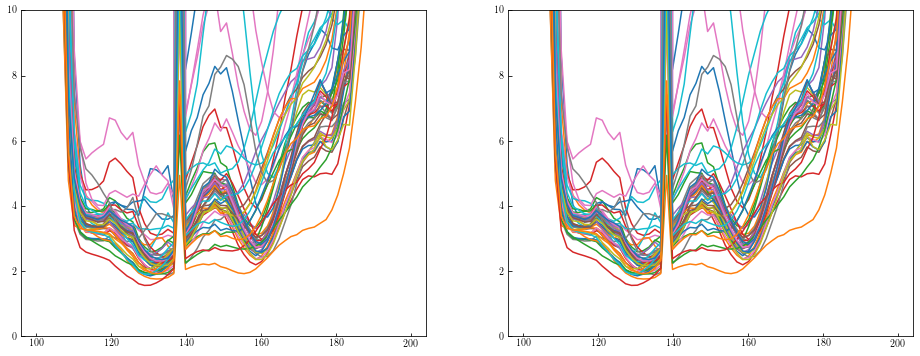

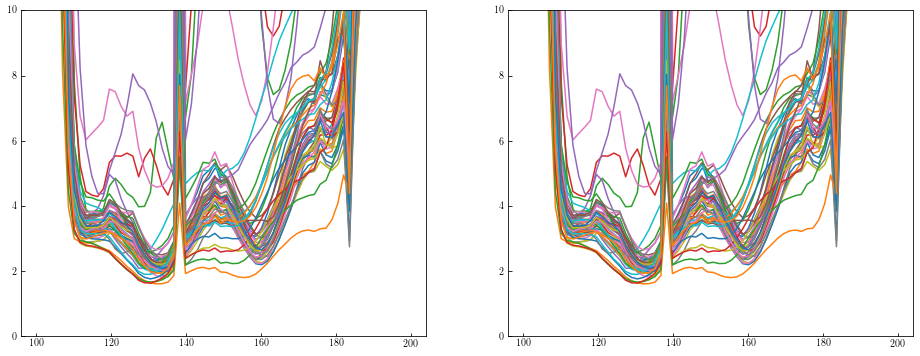

In [30]:
for poli, pol in enumerate(pols):
    fig, axarr = plt.subplots(1, 2,figsize=(16, 6))
    for anti, ant in enumerate(HERA_list):
        axarr[0].plot(freqs, rxr_temp_err[poli, anti, :])
        axarr[1].plot(freqs, rxr_temp_err_new[poli, anti, :])
    axarr[0].set_ylim([0,10])
    axarr[1].set_ylim([0,10])
    plt.show()

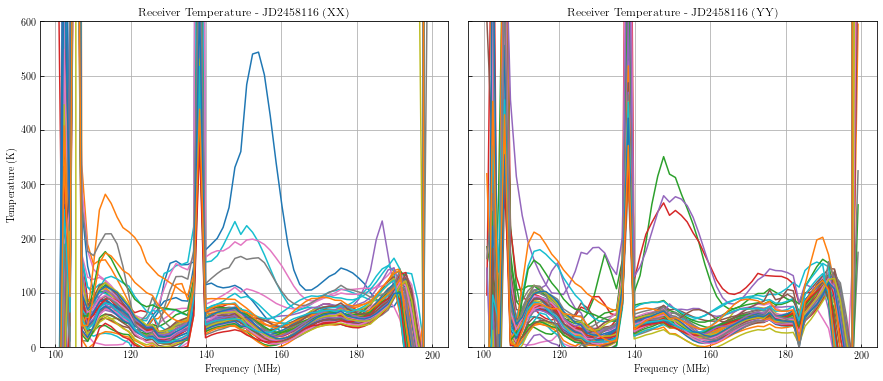

In [31]:
fig, axarr = plt.subplots(1, 2, sharey=True, figsize=(15, 6))

for poli, pol in enumerate(pols):
    for anti, ant in enumerate(HERA_list):
        axarr[poli].plot(freqs, rxr_temp[poli, anti, :], label=str(ant))
    axarr[poli].set_ylim([0,600])
    axarr[0].set_ylabel('Temperature (K)')
    axarr[0].set_xlabel('Frequency (MHz)')
    axarr[1].set_xlabel('Frequency (MHz)')
    axarr[poli].set_title('Receiver Temperature - JD{JD} ({pol})'.format(JD=jd,pol=2*pol))
    axarr[poli].grid()
    
plt.subplots_adjust(wspace=0.05)
#plt.savefig('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{JD}/receiver_temp_{JD}.png'.format(JD=JD), bbox_inches='tight')

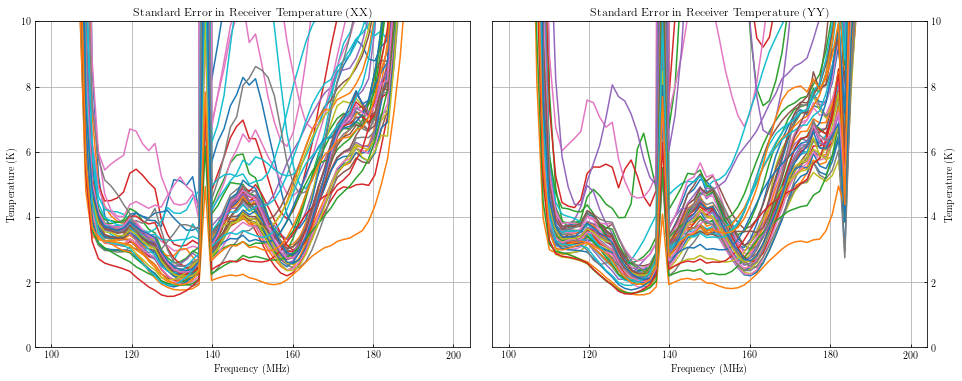

In [32]:
fig, axarr = plt.subplots(1, 2,figsize=(16, 6))

for poli, pol in enumerate(pols):
    for anti, ant in enumerate(HERA_list):
        axarr[poli].plot(freqs, rxr_temp_err[poli, anti, :], label=str(ant))
    axarr[poli].set_xlabel('Frequency (MHz)')
    axarr[poli].set_ylim([0,10])
    axarr[poli].set_ylabel('Temperature (K)')
    axarr[1].yaxis.tick_right()
    axarr[1].yaxis.set_label_position("right")
    axarr[poli].set_ylabel('Temperature (K)')
    axarr[poli].set_title('Standard Error in Receiver Temperature ({})'.format(2*pol))
    #plt.show()
axarr[0].grid()
axarr[1].grid()
plt.subplots_adjust(wspace=0.05)
#plt.savefig('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{JD}/rxr_standard_err_{pol}_{JD}.png'.format(pol=2*pol, JD=JD), bbox_inches='tight')

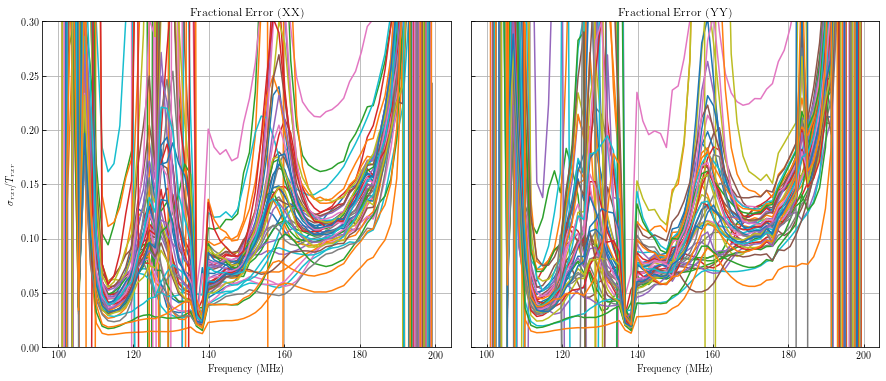

In [34]:
fig, axarr = plt.subplots(1, 2, sharey=True, figsize=(15, 6))

for poli, pol in enumerate(pols):
    for anti, ant in enumerate(HERA_list):
        '''
        if ant in bad_ants[poli]:
            axarr[poli].plot(freqs, rxr_temp_err[poli, anti, :] / rxr_temp[poli, anti, :], label=str(ant), linestyle='--')
        elif ant in [98,66,141]:
            axarr[poli].plot(freqs, rxr_temp_err[poli, anti, :] / rxr_temp[poli, anti, :], label=str(ant))
        '''
        axarr[poli].plot(freqs, rxr_temp_err[poli, anti, :] / rxr_temp[poli, anti, :], label=str(ant))
    axarr[poli].set_title('Fractional Error ({})'.format(2*pol))
    axarr[0].set_ylabel(r'$\sigma_{rxr} / T_{rxr}$')
    axarr[poli].set_xlabel('Frequency (MHz)')
    axarr[poli].set_ylim([0,0.3])
    #axarr[poli].legend()
    axarr[poli].grid()
plt.subplots_adjust(wspace=0.05)
#plt.savefig('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{JD}/rxr_fraction_err_{JD}.png'.format(JD=jd), bbox_inches='tight')


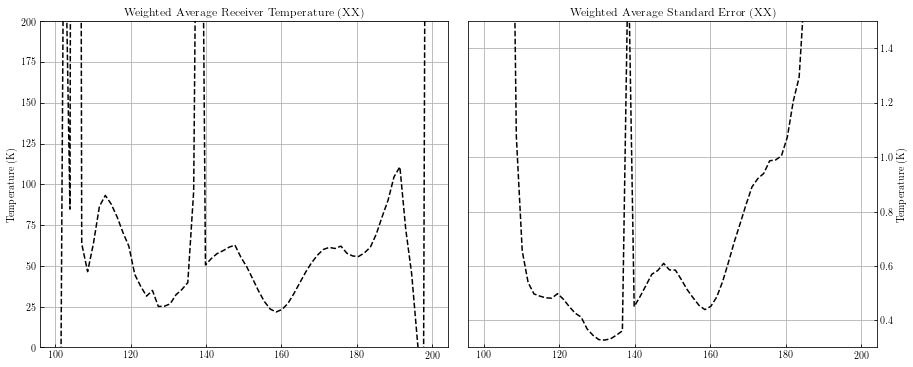

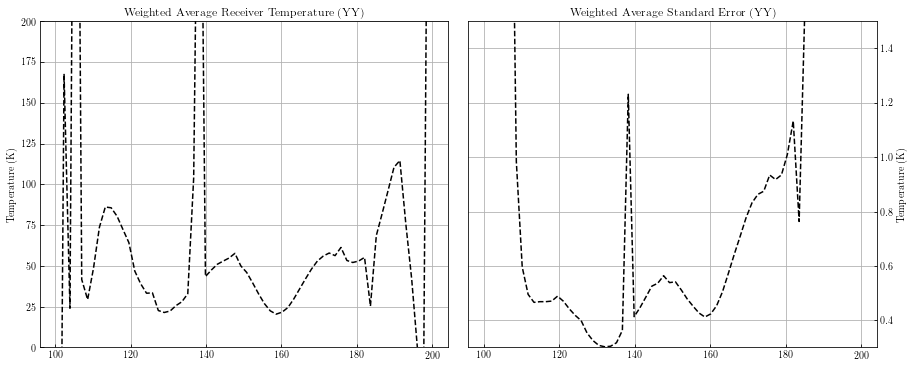

In [41]:
avg_temps = np.zeros((2, rxr_temp.shape[2]))
avg_err = np.zeros((2, rxr_temp.shape[2]))

for poli, pol in enumerate(pols):
    fig, axarr = plt.subplots(1, 2, figsize=(15, 6))
    for i in np.arange(rxr_temp.shape[2]):
        #idx_min = np.where(rxr_temp[1, :, i] > 0)[0]
        #idx = np.where(rxr_temp[1, :, i] < 1e5)[0]
        #idx = np.intersect1d(idx_min, idx_max)
        avg_temps[poli,i] = np.average(rxr_temp[poli,:,i], weights=1.0/rxr_temp_err[poli,:,i]**2)
        avg_err[poli,i] = np.sqrt(1.0 / np.sum(1.0 / rxr_temp_err[poli,:,i]**2))

    axarr[0].plot(freqs, avg_temps[poli,:], 'k--')  
    axarr[0].set_title('Weighted Average Receiver Temperature ({})'.format(2*pol))
    axarr[0].set_ylim([0,200])
    axarr[0].set_ylabel('Temperature (K)')
    axarr[1].set_ylabel('Temperature (K)')
    axarr[1].plot(freqs, avg_err[poli,:], 'k--') 
    axarr[1].set_title('Weighted Average Standard Error ({})'.format(2*pol))
    axarr[1].yaxis.tick_right()
    axarr[1].yaxis.set_label_position("right")
    axarr[1].set_ylim([0.3,1.5])
    axarr[0].grid()
    axarr[1].grid()
    plt.subplots_adjust(wspace=0.05)
    plt.show()

#np.savez('average_temp_{pol}_{JD}'.format(pol=pols[0], JD=JD), avg_temps=avg_temps, avg_err=avg_err)

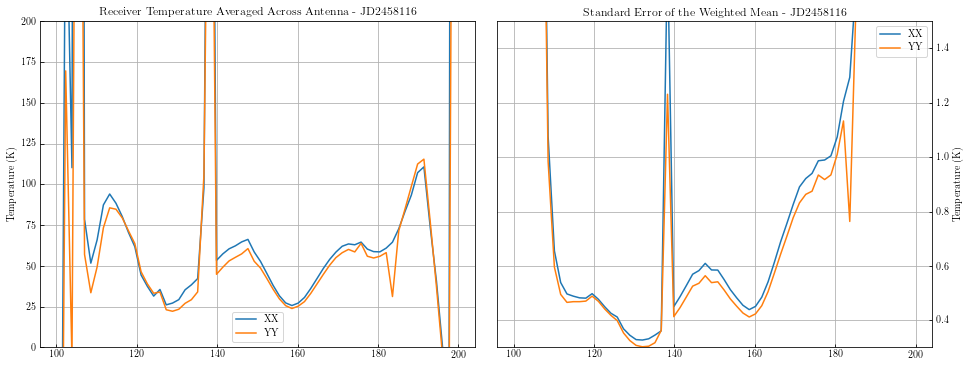

In [44]:
avg_temps = np.zeros((2, rxr_temp.shape[2]))
avg_err = np.zeros((2, rxr_temp.shape[2]))

fig, axarr = plt.subplots(1, 2, figsize=(16, 6))

for poli, pol in enumerate(pols):
    for i in np.arange(rxr_temp.shape[2]):
        avg_temps[poli,i] = np.average(rxr_temp[poli,:,i], weights=1.0/rxr_temp_err[poli,:,i])
        avg_err[poli,i] = np.sqrt(1.0 / np.sum(rxr_temp_err[poli,:,i]**(-2)) )
        
    axarr[0].plot(freqs, avg_temps[poli,:], label=str(2*pol))      
    axarr[0].set_title('Receiver Temperature Averaged Across Antenna - JD{}'.format(jd))
    axarr[0].set_ylim([0,200])
    axarr[0].set_ylabel('Temperature (K)')
    axarr[1].set_ylabel('Temperature (K)')
    axarr[1].plot(freqs, avg_err[poli,:], label=str(2*pol)) 
    axarr[1].set_title('Standard Error of the Weighted Mean - JD{}'.format(jd))
    axarr[1].yaxis.tick_right()
    axarr[1].yaxis.set_label_position("right")
    axarr[1].set_ylim([0.3,1.5])
    axarr[0].legend()
    axarr[1].legend()
    axarr[poli].grid()

plt.subplots_adjust(wspace=0.05)
#plt.show()
#plt.savefig('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{JD}/avg_temp_w_err_{JD}.png'.format(JD=jd), bbox_inches='tight')

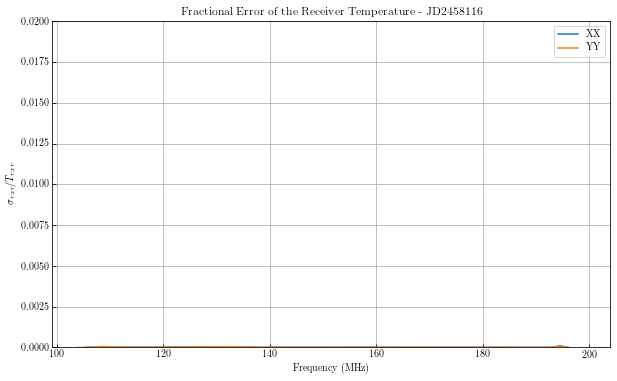

In [147]:
plt.figure(figsize=(10,6))
plt.plot(freqs, avg_err[0,:] / np.abs(avg_temps[0,:]), label='XX')
plt.plot(freqs, avg_err[1,:] / np.abs(avg_temps[1,:]), label='YY')
plt.ylim([0,0.02])
plt.title('Fractional Error of the Receiver Temperature - JD{}'.format(jd))
plt.xlabel('Frequency (MHz)')
plt.ylabel(r'$\sigma_{rxr} / T_{rxr}$')
plt.legend()
plt.grid()
#plt.show()
#plt.savefig('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{JD}/avg_fractional_err_{JD}.png'.format(JD=jd), bbox_inches='tight')

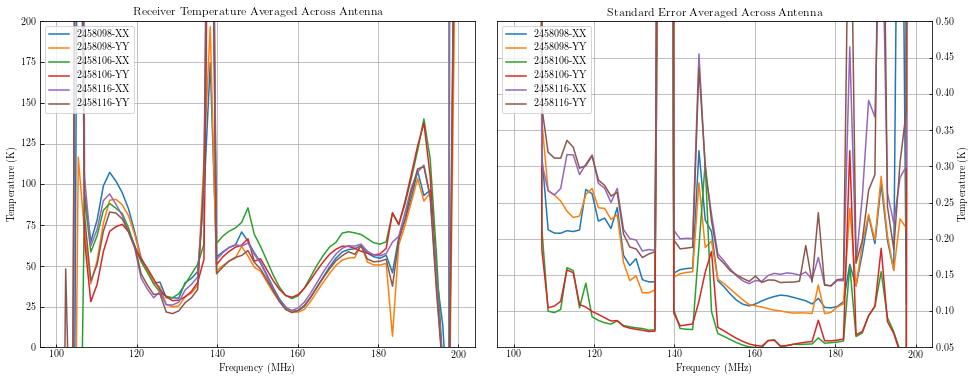

In [132]:
files = glob.glob('/Users/tyler/Desktop/Research/Tsys/data/average_*')
files.sort()
fig, axarr = plt.subplots(1, 2, figsize=(16, 6))
jds = ['2458098','2458098 Wide Beam', '2458106', '2458106 Wide Beam','2458116', '2458116 Wide Beam']
new_beam_jds = ['2458098 Wide Beam', '2458106 Wide Beam', '2458116 Wide Beam']
old_beam_jds = ['2458098', '2458106', '2458116']


for j, f in enumerate(files[::2]):
    temps = np.load(f)['avg_temps']
    errs = np.load(f)['avg_err']
    for i in np.arange(2):
        axarr[0].plot(freqs, temps[i], label=old_beam_jds[j] + '-' + 2*pols[i])
        axarr[1].plot(freqs, errs[i], label=old_beam_jds[j] + '-' + 2*pols[i])
    axarr[0].set_title('Receiver Temperature Averaged Across Antenna')
    axarr[0].set_ylim([0,200])
    axarr[0].set_ylabel('Temperature (K)')
    axarr[1].set_ylabel('Temperature (K)')
    axarr[0].set_xlabel('Frequency (MHz)')
    axarr[1].set_xlabel('Frequency (MHz)')
    axarr[1].set_title('Standard Error Averaged Across Antenna')
    axarr[1].yaxis.tick_right()
    axarr[1].yaxis.set_label_position("right")
    axarr[1].set_ylim([0.05,0.5])
    axarr[0].legend()
    axarr[1].legend()
    axarr[0].grid()
    axarr[1].grid()
plt.subplots_adjust(wspace=0.05)
#plt.savefig('averaged_receiver_temp.png', bbox_inches='tight')

Text(0.5,1,u'Fractional Errors in Receiver Temperature')

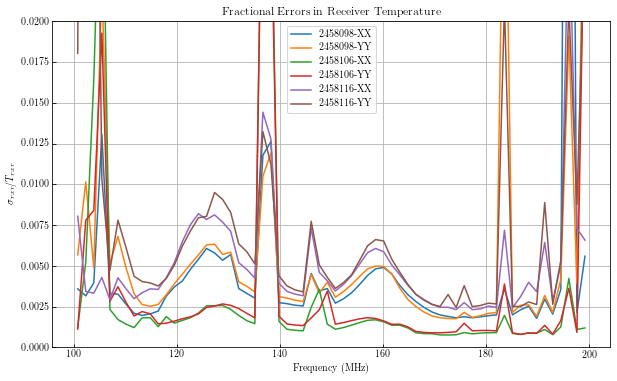

In [68]:
plt.figure(figsize=(10,6))

for j, f in enumerate(files[::2]):
    temps = np.load(f)['avg_temps']
    errs = np.load(f)['avg_err']
    for i in np.arange(2):
        plt.plot(freqs, np.abs(errs[i]/temps[i]) , label=old_beam_jds[j] + '-' + 2*pols[i])

plt.grid()
plt.legend()
plt.ylim([0,0.02])
plt.xlabel('Frequency (MHz)')
plt.ylabel(r'$\sigma_{rxr} / T_{rxr}$')
plt.title('Fractional Errors in Receiver Temperature')
#plt.savefig('fractional_errors.png', bbox_inches='tight')

In [11]:
C = np.random.uniform(-1,1,100)
A = np.random.uniform(-1,1,100)
np.dot(A,np.diag(C))

array([-0.14647542,  0.11420589,  0.07450549,  0.01036572,  0.03704583,
       -0.1532311 , -0.22819452,  0.01072316, -0.2736478 , -0.07023498,
       -0.01840196,  0.41753708,  0.42398717, -0.19390142,  0.66171038,
       -0.01675281, -0.18261805,  0.00525669, -0.08168759, -0.38539514,
        0.09676159,  0.17403043,  0.30632791, -0.33180307, -0.57826398,
       -0.22133064, -0.20475027, -0.02717596,  0.32680863, -0.15287199,
        0.16224306, -0.1980926 ,  0.2179288 ,  0.46163715,  0.0324801 ,
       -0.09308029, -0.201947  ,  0.44679308, -0.06165862, -0.07435065,
       -0.03326956,  0.24685483, -0.03909879,  0.16664948, -0.46505825,
       -0.17341374, -0.31450485,  0.17907847,  0.12632749,  0.44454597,
       -0.52015129,  0.09656894, -0.0180016 ,  0.05222089,  0.38106488,
        0.30442346,  0.04773438,  0.07748529,  0.16956603, -0.18905621,
        0.6778065 , -0.37356171,  0.2964358 ,  0.40996284, -0.00183021,
        0.03474541, -0.20522884, -0.47661837,  0.02763399, -0.14